# Credit risk scoring project
## Decision Trees and Ensemble Learning

## 0. Imports

In [241]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [242]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [243]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## 1. Data processing

In [244]:
df.columns = df.columns.str.lower()

In [245]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [246]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [247]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [248]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [249]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [250]:
df = df[df.status != 'unk'].reset_index(drop=True)

## 2. Validation Framework

In [251]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [252]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [253]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [254]:
del df_train['status']
del df_val['status']
del df_test['status']

In [255]:
print (len(df_train), len(df_val), len(df_test))

2672 891 891


## 3. Using decision trees

In [256]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [257]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [258]:
y_pred = dt.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred)

y_pred = dt.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred)

print('Train:', auc_train)
print('Validation:', auc_val)

Train: 1.0
Validation: 0.6602346758373496


Model is overfitted:
- Depth is unlimited -> model learns too specific rules

In [259]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [260]:
y_pred = dt.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred)

y_pred = dt.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred)

print('Train:', auc_train)
print('Validation:', auc_val)

Train: 0.8433781899611289
Validation: 0.7669377103969388


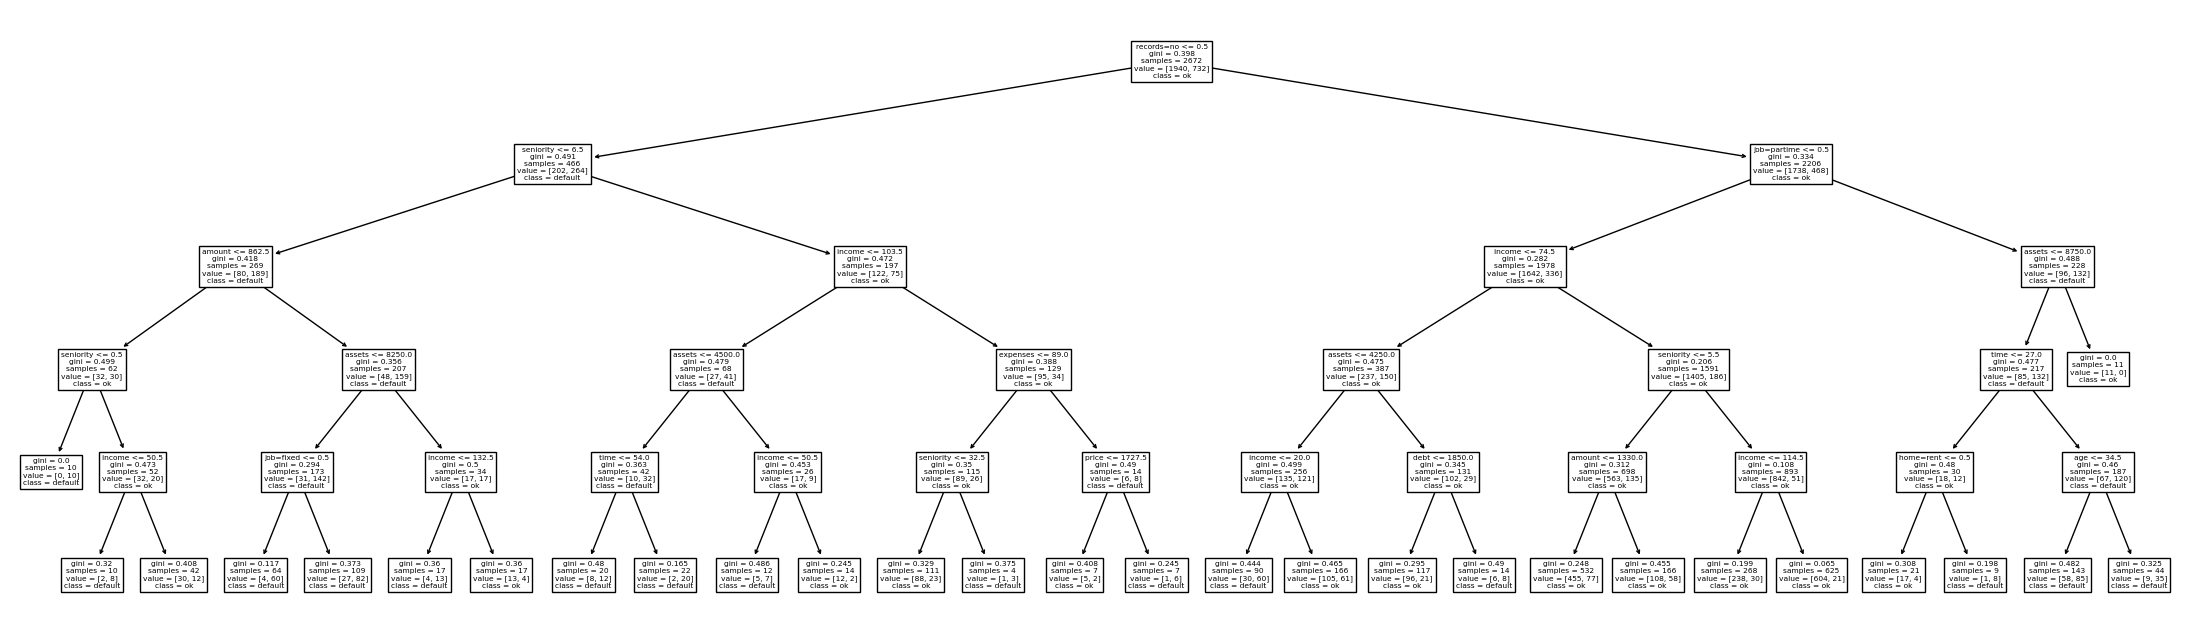

In [261]:
from sklearn.tree import plot_tree
plt.figure(figsize=(28,8))
plot_tree(dt, feature_names=dv.get_feature_names_out(), class_names=['ok','default']);

### 3.1 Hyperparameter tuning

5.0

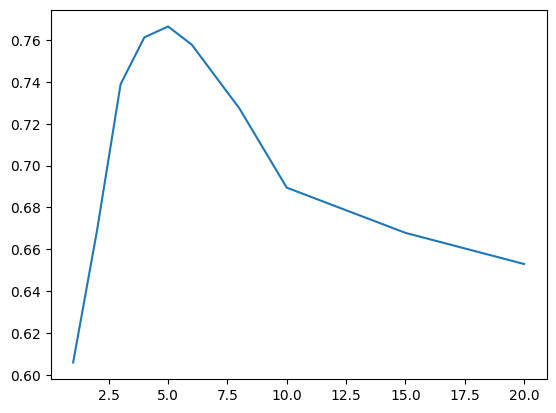

In [262]:
auc_scores = {}
for d in [1,2,3,4,5,6,8,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    auc_scores[d] = auc
pd.Series(auc_scores).plot()
pd.Series(auc_scores).idxmax()

In [263]:
auc_scores = pd.DataFrame()
i=0
for d in [4,5,6,7,8,9,10,11,12,14,16,18,20,40,None]:
    for s in [1,2,5,10,11,12,14,15,16,17,18,20,50,100,200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        auc_scores.loc[i,'max_depth'] = d
        auc_scores.loc[i,'min_samples_leaf'] = s
        auc_scores.loc[i,'score'] = auc
        i+=1
auc_scores.sort_values('score', ascending=False).reset_index(drop=True).head()

,max_depth,min_samples_leaf,score
0,10.0,16.0,0.792225
1,9.0,16.0,0.791226
2,20.0,16.0,0.791220
3,10.0,15.0,0.790914
4,6.0,16.0,0.790714


<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

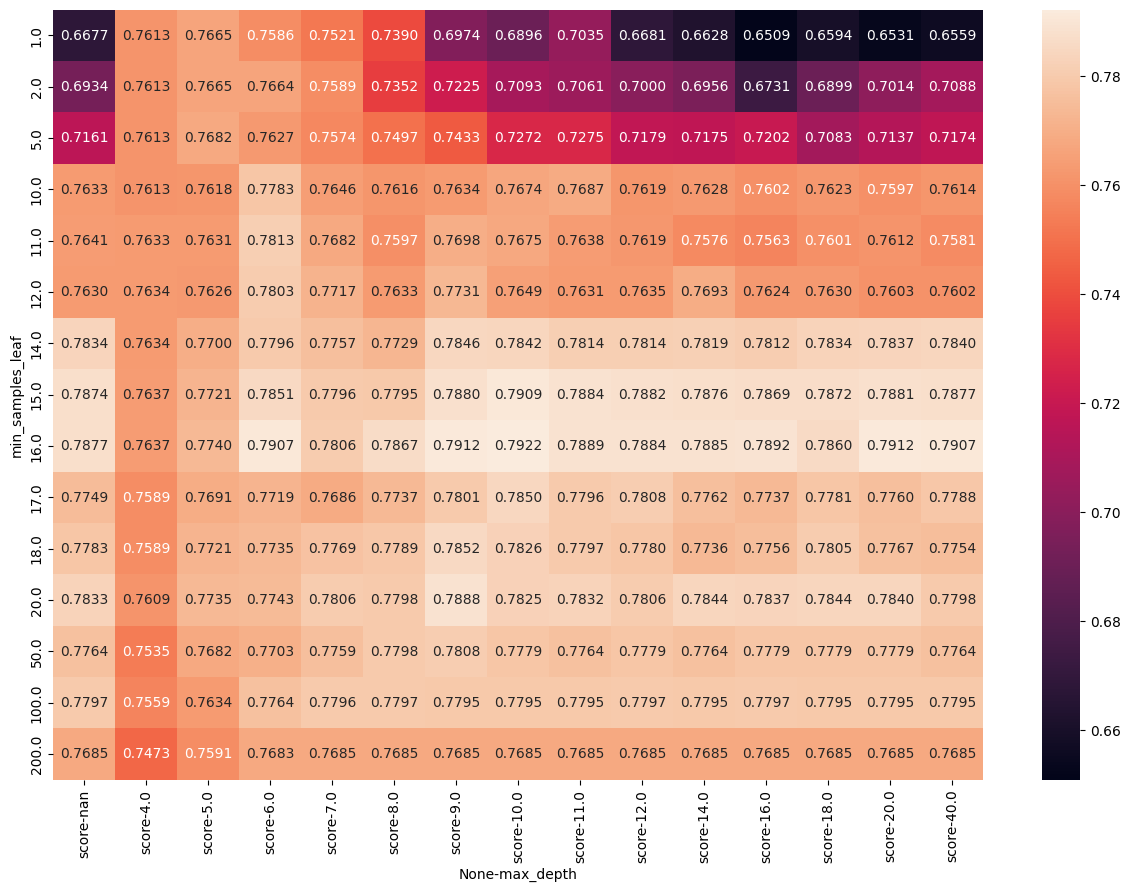

In [264]:
df_scores = auc_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['score'])
plt.figure(figsize=(15,10))
sns.heatmap(df_scores, annot=True, fmt='.4f')

Final model:

In [265]:
dt = DecisionTreeClassifier(max_depth=12, min_samples_leaf=16)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=16)

## 4. Ensembles and random forest

In [266]:
from sklearn.ensemble import RandomForestClassifier

In [267]:
rf = RandomForestClassifier(n_estimators=3, random_state=1).fit(X_train, y_train)

In [268]:
y_pred = rf.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred)

y_pred = rf.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred)

print('Train:', auc_train)
print('Validation:', auc_val)

Train: 0.9795824883105176
Validation: 0.7168481024920685


<AxesSubplot:xlabel='n_estimators'>

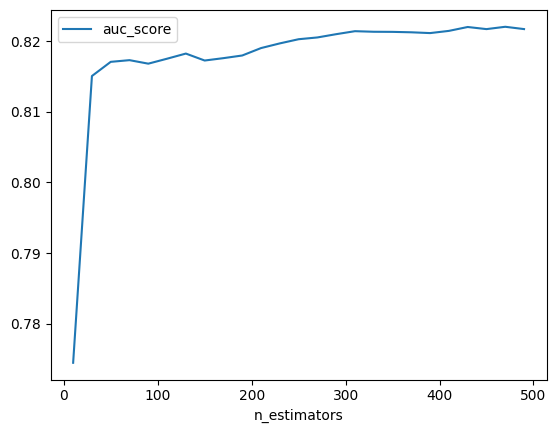

In [269]:
scores=[]
for n in range(10,500,20):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))
pd.DataFrame(scores, columns=['n_estimators', 'auc_score']).plot(x='n_estimators', y='auc_score')

In [270]:
scores=[]
for d in [5,7,9,10,11,12,13,14,15,16,17]:
    for n in range(100,400,20):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((n,d,auc))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'auc_score'])

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estimators'>

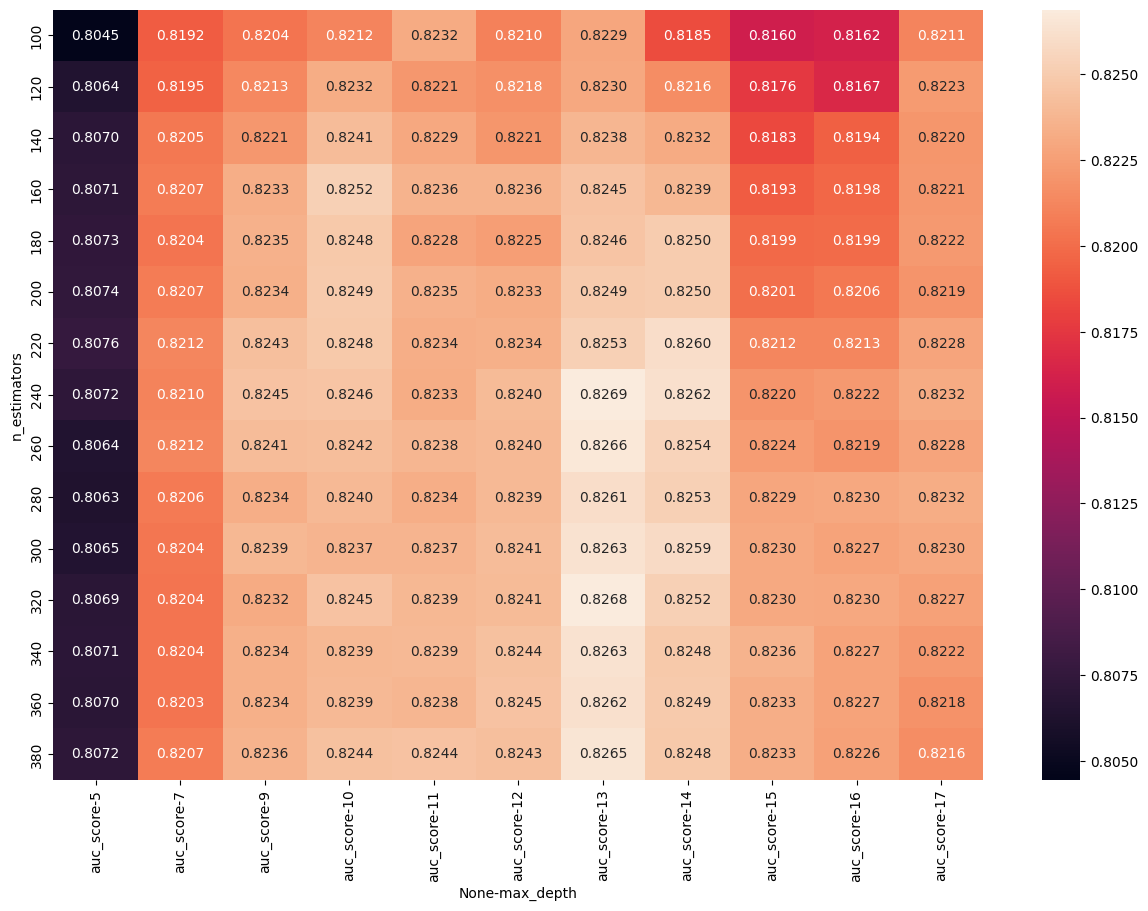

In [271]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['auc_score'])
plt.figure(figsize=(15,10))
sns.heatmap(df_scores_pivot, annot=True, fmt='.4f')

In [272]:
max_depth=13

In [273]:
scores = []

for s in [1, 2, 3, 4, 5]:
    for n in range(100,400,20):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

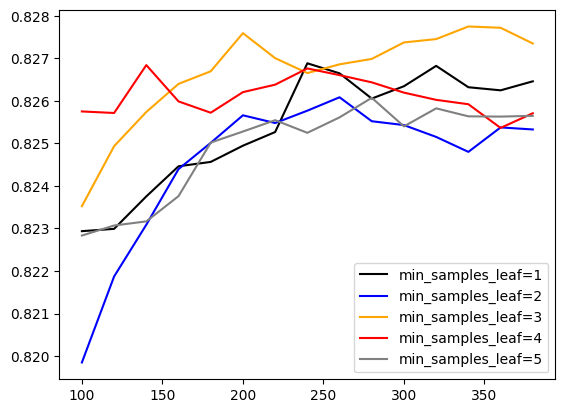

In [274]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 2, 3, 4, 5]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

<AxesSubplot:xlabel='None-min_samples_leaf', ylabel='n_estimators'>

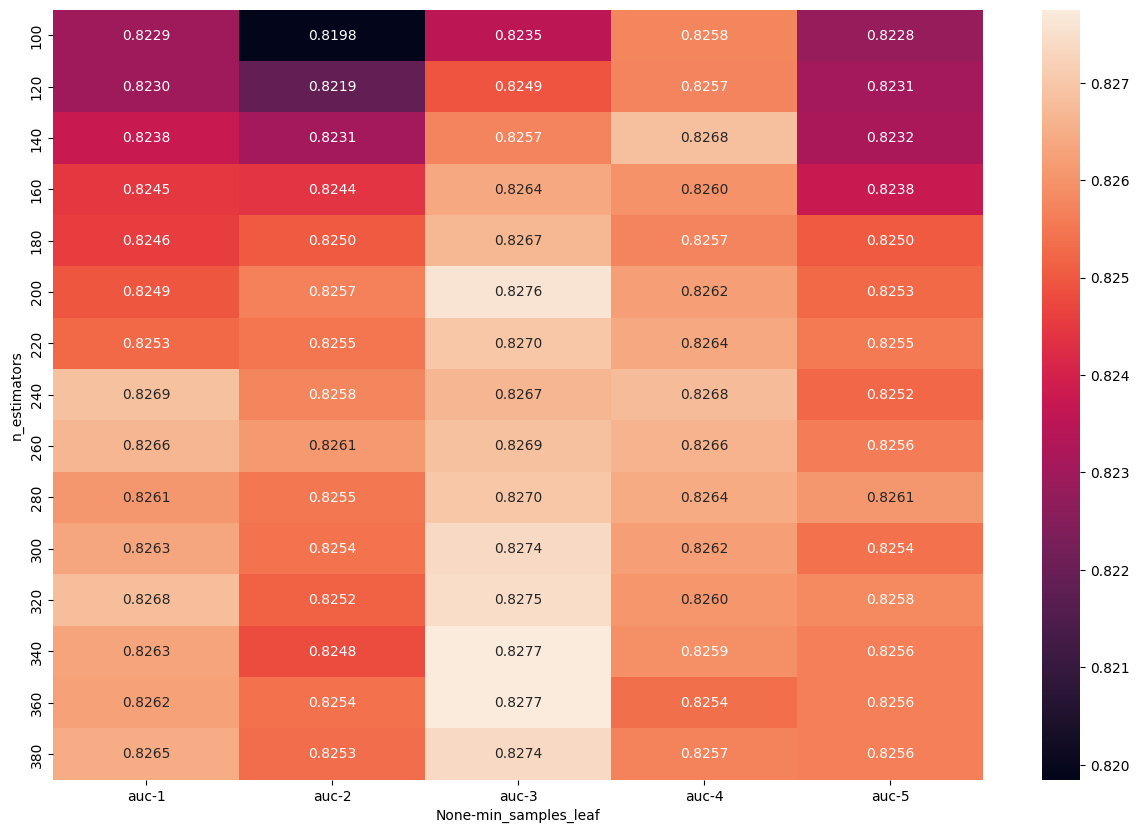

In [275]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['min_samples_leaf'], values=['auc'])
plt.figure(figsize=(15,10))
sns.heatmap(df_scores_pivot, annot=True, fmt='.4f')

In [276]:
# parameters
max_depth = 10
min_samples_leaf = 3
n_estimators = 200

# model
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

Other useful parametes:
- max_features
- bootstrap

## 5. Gradient Boosting

In [340]:
import xgboost as xgb

In [341]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [342]:
%%capture output

xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}

watchlist = [(dtrain,'train'),(dval,'validation')]

model = xgb.train(xgb_params, dtrain,
                evals=watchlist,
                verbose_eval=5,
                num_boost_round=200)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)               

In [343]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_results = parse_xgb_output(output)
df_results.head()

,num_iter,train_auc,val_auc
0,0,0.86283,0.76511
1,5,0.92535,0.80448
2,10,0.95341,0.81160
3,15,0.96318,0.81507
4,20,0.97349,0.82036


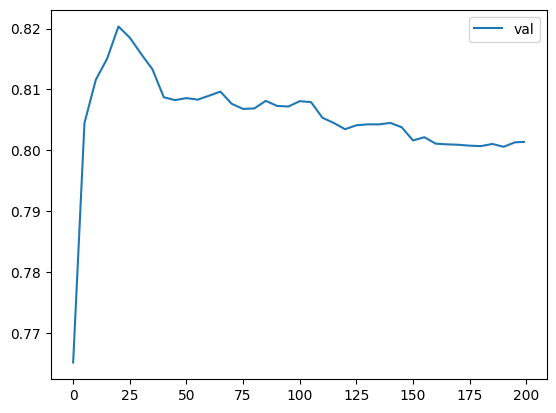

In [344]:
plt.plot(df_results.num_iter, df_results.val_auc, label='val')
plt.legend()

### 6.1 XGBoost Hyperpameter Tuning

- eta

In [345]:
%%capture output

xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [346]:
scores = {}

In [347]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [348]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [349]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [350]:
%%capture output

xgb_params = {
    'eta':0.01,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [351]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [352]:
%%capture output

xgb_params = {
    'eta':0.001,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [353]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [354]:
%%capture output

xgb_params = {
    'eta':1,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [355]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01', 'eta=0.001', 'eta=1'])

In [356]:
%%capture output

xgb_params = {
    'eta':0.05,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [357]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01', 'eta=0.001', 'eta=1', 'eta=0.05'])

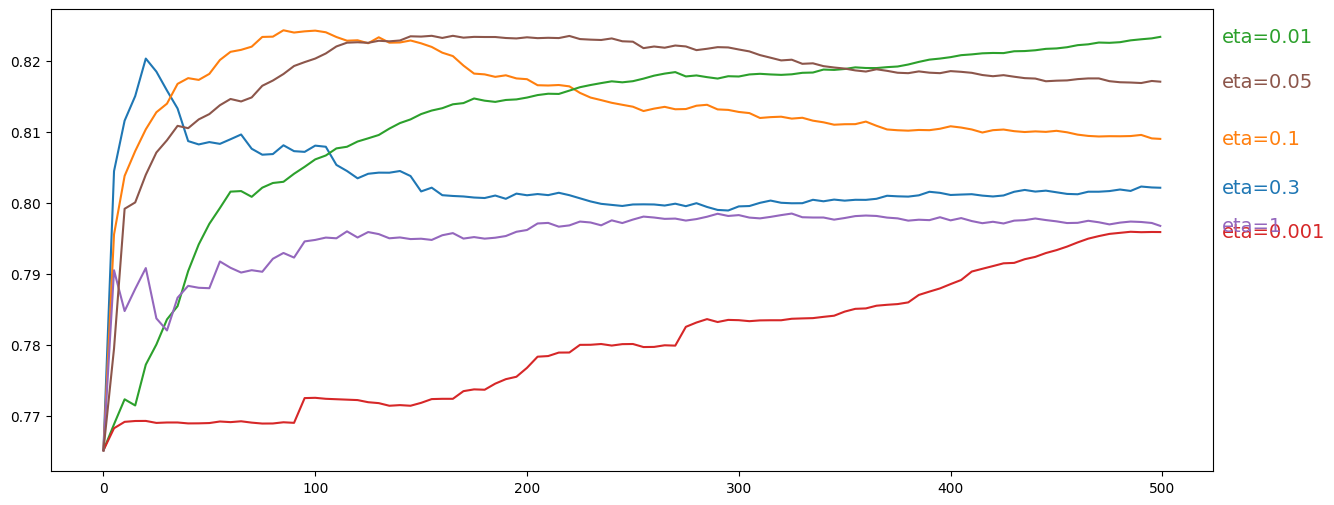

In [358]:
plt.figure(figsize=(15,6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=key)

ax = plt.gca()
for line, key in zip(ax.lines, scores.keys()):
    y = line.get_ydata()[-1]
    ax.annotate(key, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
plt.show()

In [364]:
scores['eta=0.1'].sort_values('val_auc', ascending=False).head()

,num_iter,train_auc,val_auc
17,85,0.98460,0.82435
20,100,0.98884,0.82430
19,95,0.98743,0.82420
21,105,0.99028,0.82407
18,90,0.98613,0.82403


- max_depth

In [367]:
scores = {}

In [368]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['max_depth=3'])

In [370]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':4,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [371]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['max_depth=3', 'max_depth=4'])

In [372]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':10,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [373]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=10'])

In [374]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [375]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=10', 'max_depth=6'])

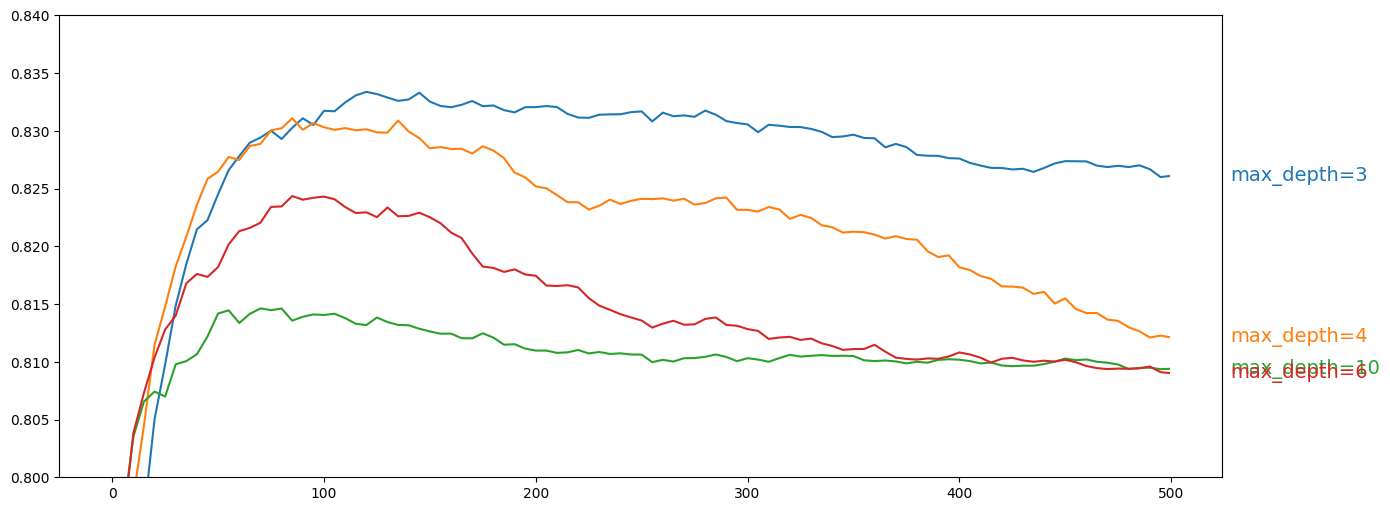

In [379]:
plt.figure(figsize=(15,6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=key)

ax = plt.gca()
for line, key in zip(ax.lines, scores.keys()):
    y = line.get_ydata()[-1]
    ax.annotate(key, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
                
plt.ylim(0.80, 0.84)
plt.show()

- min_child_weight

In [380]:
scores = {}

In [381]:
scores['eta=0.1'].sort_values('val_auc', ascending=False).head()%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [382]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['min_child_weight=1'])

In [383]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':5,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [384]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=5'])

In [385]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':10,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [386]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=5', 'min_child_weight=10'])

In [387]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':15,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [388]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=5', 'min_child_weight=10', 'min_child_weight=15'])

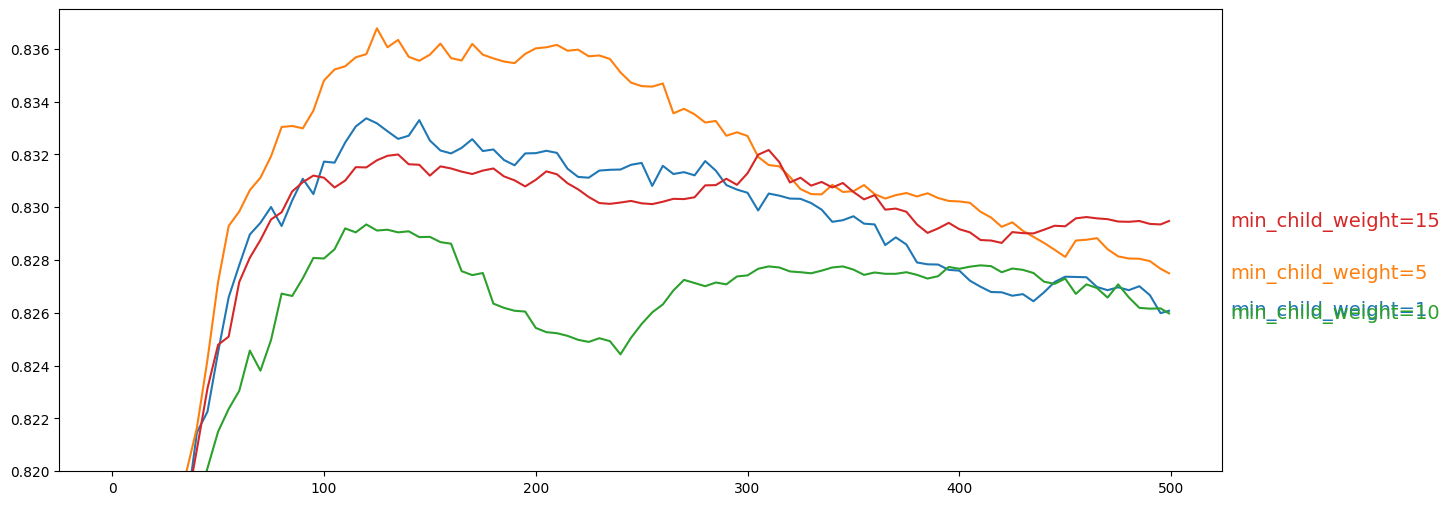

In [392]:
plt.figure(figsize=(15,6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=key)

ax = plt.gca()
for line, key in zip(ax.lines, scores.keys()):
    y = line.get_ydata()[-1]
    ax.annotate(key, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
                
plt.ylim(0.82, 0.8375)
plt.show()

In [404]:
scores['min_child_weight=5'].sort_values('val_auc', ascending=False).head()

,num_iter,train_auc,val_auc
25,125,0.91580,0.83678
27,135,0.91702,0.83634
31,155,0.92025,0.83620
34,170,0.92272,0.83619
42,210,0.92811,0.83615


- Final parameters

In [ ]:
xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':5,
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric':'auc',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=175,
                  verbose_eval=5,
                  evals=watchlist)

Other useful parametes:
- subsample and colsample_bytree
- lambda and alpha

## 7. Choosing the final model

In [394]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850802838390931

In [395]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [399]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 5,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'tree_method': 'gpu_hist',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=125)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8359055242062436

## 8. Train and evaluate final model

In [400]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']

In [421]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [422]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [425]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'n_jobs': -1,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8322662626460096

<AxesSubplot:>

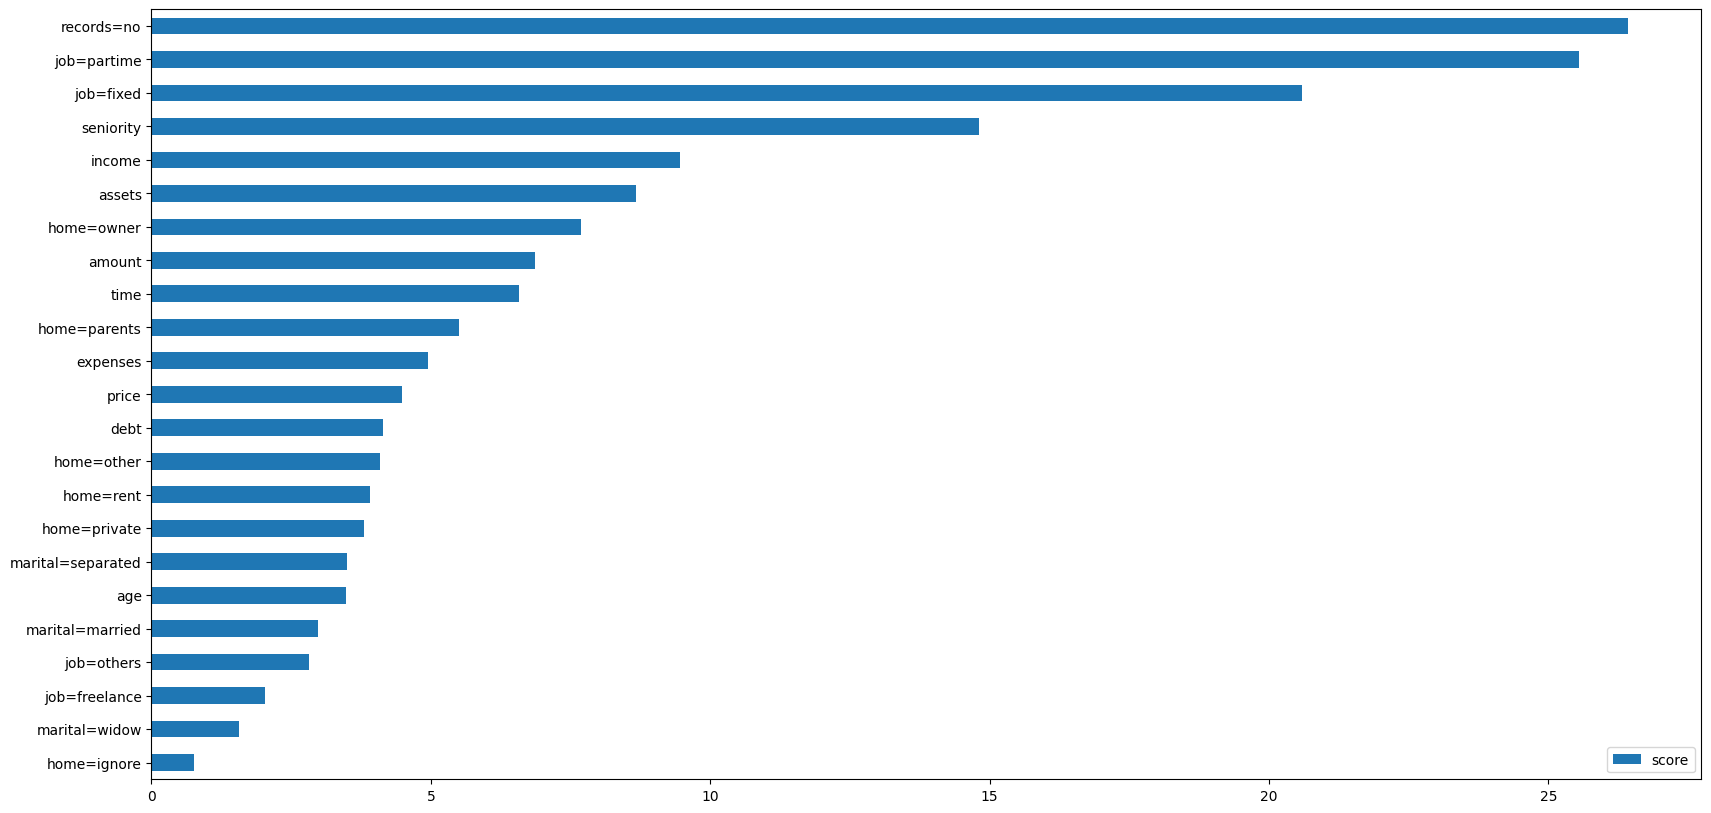

In [437]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10)) 